# IPSA 2021 - Exercise 3 - Fun with Fourier Transforms

## 0 - Practical Advice

In [1]:
import imageio 
import numpy as np
import numpy.fft as fft
import numpy.random as rnd
import scipy.ndimage as img
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import timeit, functools

In [2]:
def imageScaleRange(f, vmin=0, vmax=255):
    """Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255"""
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

## 1 - Uni-variate Gaussians and their derivatives

An unnormalized, uni-variate Gaussian function $f : \mathbb{R} \rightarrow \mathbb{R}$ with location parameter $\mu \in \mathbb{R}$ and scale parameter $\sigma \in \mathbb{R}_+$ is given by
\begin{equation}
f(x \mid \mu, \sigma) = \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} (x - \mu)^2}
\end{equation}
The following plot was created with parameters $\mu = 0$ and $\sigma \in \{ 0.5, 1.0, 2.0\}$ and illustrates how such functions look like for $x \in [-7, +7)$

![Gaussians1D-2.png](attachment:Gaussians1D-2.png)

### 1 (a) Compute the (symbolic) derivative of the Gaussian function

Using the chain rule: 
$$ f(x) = e^{u(x)} \ \implies \ f'(x) = u'(x) * e^{u(x)} $$

We can compute the derivative of the Gaussian function as:
\begin{align}
\frac{d}{dx} f(x \mid \mu, \sigma) 
&= \frac{d}{dx}\exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \frac{d}{dx}\Big[ - \frac{(x - \mu)^2}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \frac{d}{dx}\Big[ - \frac{x^2 -2x\mu + \mu^2}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \Big[ - \frac{2x - 2\mu}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= -\frac{(x- \mu)}{\sigma^2} f(x \mid \mu, \sigma)\\
&= \frac{(\mu - x)}{\sigma^2} f(x \mid \mu, \sigma)
\end{align}

### 1 (b) Use your result and the same parameters as above to create a plot that shows Gaussian derivatives and enter it here:

In [56]:
def writeFigure(fig, fname):
    fmt = fname.split('.')[-1]
    fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
                papertype='letter', format=fmt, transparent=False,
                bbox_inches='tight', pad_inches=0)

def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # Initialize figure and axes
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # Nicer way of showing coordinate axes
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    # Plot the function
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

    # Plot the legend
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
    
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # Show figure on screen or write it to disc
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

In [4]:
def fctG(x, mu=0., sig=1.):
    """Gaussian function"""
    return np.exp(-0.5 * (x-mu)**2 / sig**2)

def ddxG(x, mu=0., sig=1.):
    """Derivative of the Gaussian function"""
    return -(x-mu) / sig**2 * fctG(x, mu, sig)

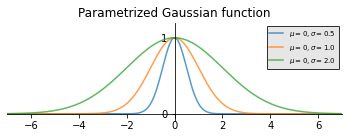

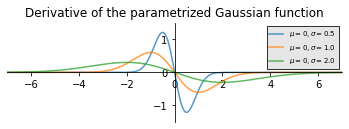

In [57]:
xmin = -7
xmax = +7
rate = 1024
xval = np.linspace(xmin, xmax, rate, endpoint=False)


sigs = [0.5, 1.0, 2.0]
labs = [r'$\mu = 0, \sigma = %.1f$' % sig for sig in sigs]



# Plot three Gaussians
fcts = [fctG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -0.1, 1.2]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Parametrized Gaussian function")


# plot their derivatives
fcts = [ddxG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Derivative of the parametrized Gaussian function")

## 2 - Working with Labraries for Symbolic Computing

In this course, we work extensively with the python modules `numpy` / `scipy` because they provide numerous functionalities for numerical computing and number crunching. However, during the lectures, we also mentioned software for symbolic computation. Maybe you have come across such software before? Maybe you have heard of Wolfram Mathematica? For python, functionalities for symbolic computation are provided by the `sympy` module. To see what it buys you, execute the following snippet:

In [6]:
! if conda list | grep sympy; then echo 1; else conda install -y sympy; fi

/bin/bash: conda: command not found
/bin/bash: conda: command not found


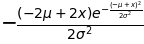

In [7]:
from sympy import *
from IPython.display import display

init_printing(use_unicode=True)

x, mu, sigma = symbols('x mu sigma')

fctF = exp(-(x-mu)**2 / (2*sigma**2))

ddxF = Derivative(fctF, x)

display(ddxF.doit())

## 3 - Fourier Transforms of Gaussians and their Derivatives

**Note:** in what follows, we will (for convenience) simplify the Gaussian as well as our notation for this function. First of all, we will drop the location parameter $\mu$ (when creating the plots in task 3.1, we did set it to zero anyway). Second of all, we will no longer explicitly write the dependence on the scale parameter $\sigma$. In short, in what follows, we are concerned with Gaussians of the form:
\begin{equation}
f(x) = \exp \left( - \frac{x^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} x^2}
\end{equation}  

Observe that Gaussian functions are square integrable and therefore have Fourier transforms. In fact, the Fourier transforms of Gaussians centered at zero, i.e. without location parameter $\mu$, are remarkably simple. While the Fourier transform $F(\omega)$ of a function $f(x)$ is typically a complex valued function, the Fourier transform of a Gaussian centered at zero is a real valued function. You can work this out for yourselves.

### 3 (a) Symbolically compute the Fourier transform of the simplified version from above

Reference: https://docs.sympy.org/latest/modules/integrals/integrals.html#sympy.integrals.transforms.fourier_transform

In [52]:
from sympy import fourier_transform, exp
from sympy.integrals.transforms import _fourier_transform
from sympy.abc import x, k, s

sigma = symbols('sigma')

FTf = fourier_transform(exp(-x**2/(2*sigma**2)), w, k)
display(FTf.doit())

gaussian = exp(-x**2/(2*sigma**2))
fct = _fourier_transform(gaussian, w, k, 1/sqrt(2*pi), -1, "", simplify=True)
display(fct.doit())

*Note: An unevaluated return indicates that SymPy was not able to calculate the Fourier Transform.*

In the mathematical computation we will make use of the fact that $\sin(x)=\frac{1}{2i}\big( e^{ix} - e^{-ix} \big)$ and $\cos(x)=\frac{1}{2}\big( e^{ix} + e^{-ix} \big)$. More explicitly we will use that:
\begin{equation}
    \exp(-i\omega x) = \frac{1}{2} \big( e^{ix} - e^{-ix} \big)- \frac{1}{2}\big( e^{ix} + e^{-ix} \big) = \cos(i\omega x) - i\sin(i\omega x)
\end{equation}

With that in mind it is:
\begin{align}
F(\omega) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \exp(-i\omega x) dx \\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \Big( \cos(i\omega x) - i \sin(i\omega x) \Big) dx \\
&= \frac{1}{\sqrt{2\pi}} \Big[ \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(i\omega x) dx - i \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \sin(i\omega x) dx \Big]\\ 
&= \frac{1}{\sqrt{2\pi}} \Big[ \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(i\omega x) dx + 0 \Big]
\end{align}

The second term is zero, since all occuring functions in the integral are odd ($\sin(x)=\sin(-x)$ and $x^2 = (-x)^2$), and the integral is computed over a symmetric domain.

Lets continue:
\begin{align}
F(\omega) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(i\omega x) dx
\end{align}

### 3 (b) The Fourier transform of a zero mean Gaussian is another (scaled) Gaussian

To make a long story short, above you should have found that the Fourier transform of the Gaussian from above amounts to

$$ F(\omega) = \sigma \exp\Big(-\frac{1}{2} \sigma^2 \omega^2\Big)$$

Use this result to plot the Fourier transforms of zero mean Gaussians
with $\sigma \in \{0.5, 1.0, 2.0\}$ over the interval $\omega\in[−7, +7)$ and enter your
plot here:

In [61]:
def spcG(x, sig=1.):
    """Simplified, zero mean Gaussian."""
    return np.exp(-0.5 * x**2 / sig**2)

def frqG(o, sig=1.):
    """Fourier transform of the zero mean Gaussian"""
    return sig * spcG(o, 1/sig)

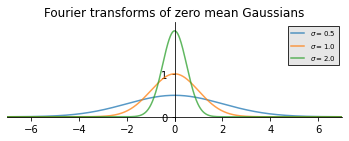

In [60]:
omin = -7
omax = +7
rate = 1024
oval = np.linspace(omin, omax, rate, endpoint=False)


sigs = [0.5, 1.0, 2.0]
labs = [r'$\sigma = %.1f$' % sig for sig in sigs]


# Plot three Gaussian Fourier transforms
fcts = [frqG(oval, sig=sig) for sig in sigs]

lims = [omin, omax, -0.1, 2.2]
xtcs = np.arange(omin+1, omax, 2)
ytcs = [-1, 0, +1]
plotFcts(oval, fcts, labs=labs, xtcs=xtcs, ytcs=ytcs, lims=lims, title='Fourier transforms of zero mean Gaussians')

### 3 (c) Fourier transform of Gaussians with non-zero mean

At this point, you might (or better should) be wondering how to compute the Fourier transform of a Gaussian that is not centered
at zero but at some $\mu\neq 0$.

To answer this question, we can use the translation invariance of the Fourier transform we discussed in the lecture.
Note that we can shift the input variable by setting $x - \mu$, to obtain a translated Gaussian:

\begin{equation}
f(x-\mu) = \exp\Big( -\frac{(x-\mu)^2}{2\sigma^2} \Big)
\end{equation}

But the Fourier transform of a translated function can be computed as ...

What do you observe? Is the Fourier transform of a shifted or translated Gaussian still a real valued function?

### 3 (d) Using the inverse Fourier transform to compute a derivative

Now that we know the Fourier transform of a zero mean Gaussian, we can use the inverse Fourier transform to compute the derivative of 
$$ f(x) = \exp\Big(-\frac{x^2}{2 \sigma^2 }\Big)$$

because
$$ \frac{\partial}{\partial x} f(x) = \mathcal{F}^{-1}\Big\{\mathcal{F}\Big\{ \frac{\partial}{\partial x} f(x) \Big\}\Big\} = \mathcal{F}^{-1} \{i\omega F(\omega)\} $$

Compute this inverse.

## 4 - Numerically computing Fourier Tranforms of Gaussians

n all the previous tasks of this exercise sheet, we were concerned with symbolic computations. Now, we will get back to numeric computations.

Our first corresponding task (this one) is a bit unusual in that we provide its solution. However, you really should carefully go through the following because it clarifies a critical issue you must know about. 

Above, you saw that the first derivative of a zero mean Gaussian can be computed as

$$ \frac{\partial}{\partial x} f(x) = \mathcal{F}^{-1}\Big\{\mathcal{F}\Big\{ \frac{\partial}{\partial x} f(x) \Big\}\Big\} = \mathcal{F}^{-1} \{i\omega F(\omega)\} $$

Let us verify this numerically. To this end, run the following snippet:

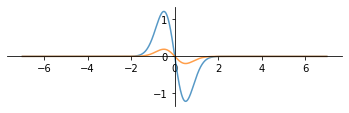

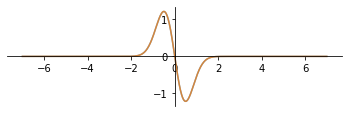

In [63]:
import numpy.fft as fft

N = 1024
xmin = -7
xmax = +7
xval = np.linspace(xmin, xmax, N, endpoint=False)
oval = fft.fftfreq(N, (xmax-xmin)/N)

s = 0.5
f = np.exp(-0.5 * xval**2 / s**2)
dfV1 = -xval / s**2 * np.exp(-0.5 * xval**2 / s**2)

F = fft.fft(f)
dfV2 = fft.ifft(1j * oval * F)

dfV2 = np.real(dfV2)

lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, [dfV1, dfV2])


dfV2 = fft.ifft(2*np.pi * 1j * oval * F)
dfV2 = np.real(dfV2)

lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, [dfV1, dfV2])

Given our discussion so far, we would assume that arrays `dfV1` and `dfV2` contain the same values, right? So, go ahead and inspect their content.

What you should find is that they differ. Perhaps this difference is due to the numerical instabilities we discussed in the lecture? Hence, execute the following snippet:

In [64]:
dfV2 = np.real(dfV2)

and inspect `dfV1` and `dfV2` again.

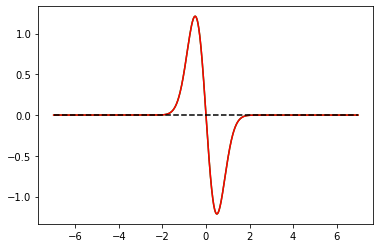

In [73]:
plt.plot(xval, dfV1, '-', c='green')
plt.plot(xval, dfV2, '-', c='red')
plt.plot(xval, dfV2-dfV1, '--', c='black')
plt.show()

What your inspection should have revealed is that there is still a systematic deviation between the content of array `dfV1` and array `dfV2`. Here is how to remedy this situation:

In [74]:
dfV2 = fft.ifft(2*np.pi * 1j * oval * F)
dfV2 = np.real(dfV2)

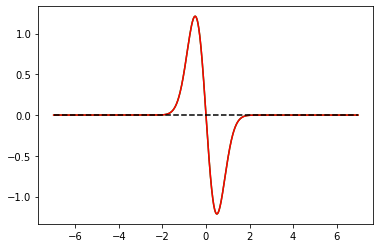

In [75]:
plt.plot(xval, dfV1, '-', c='green')
plt.plot(xval, dfV2, '-', c='red')
plt.plot(xval, dfV2-dfV1, '--', c='black')
plt.show()

Now you should see that both arrays are basically identical (up to numerical precision). What is going on here? Why would a multiplication by a factor of $2\pi$ cause our practical computation to agree with our theoretical expectation?

The answer has to do with how we derived and subsequently defined the Fourier transform and its inverse.

%TODO: Fourier and inverse

Two key steps during our derivation were the introduction of the *angular frequency* $\omega = \frac{2 \pi}{T k}$ and the limiting process $T\to\infty$. Note, however, that there is no “canonical” way of writing down the Fourier transform and its inverse. There are only different “conventions”. Another common convention
is to consider the simple frequency $\xi = \frac{k}{T}$ and to let $T\to\infty$.

Considering the definition of $\xi$, we realize that we can write $\omega = 2\pi d\xi$ and thus $d\omega = 2 \pi d\xi$. Expressed in terms of $\xi$, the Fourier transform and its corresponding verse become:

%TODO: Fourier and inverse with 2nd convention

With respect to the basic nature of the Fourier transform, the many different
notational conventions do not really matter. They are but different ways of writing down the same concept. Yet, they do impact the way statements about properties of the Fourier transform have to be expressed.
For instance, when following the convention we work with in this course, the fact that the Fourier transform turns differentiation into multiplication is expressed as

$$ \mathcal{F}\Big\{ \frac{\partial}{\partial x} f(x) \Big\} = i\omega \mathcal{F}\{f(x)\} $$

However, in the convention we just discussed, it reads

$$ \hat{\mathcal{F}}\Big\{ \frac{\partial}{\partial x} f(x) \Big\} = 2\pi i\omega \hat{\mathcal{F}}\{f(x)\} $$

or which we point out the appearance of the factor $2\pi$.

Now consider the discrete Fourier transform and its inverse:

These are computed by the numpy functions `fft.fft` and `fft.ifft` are indeed commonly defined w.r.t. to simple frequencies rather than w.r.t. angular frequencies. This is why we have to introduce the factor of $2\pi$ and
use the statements

`dfV2 = fft.ifft(2*np.pi * 1j * oval * F)`

`dfV2 = np.real(dfV2)`

in order to numerically obtain the result which theory told us to expect.

What is to be learned from this? It is an unfortunate fact of life in the hard
(i.e. math-based) sciences that mathematical notation for more abstract concepts is not always set in stone. We all know this from experience and either did already or still have to learn to live with this. By and large
this is no problem and the longer our careers in the sciences last, the easier it is for us to recognize different notations for what they are, namely nothing but different ways of writing down the same thing. In fact, we are used to something similar in our daily lives: hardly ever will different people we are talking to use the exact same phrases to express the same thing. Nevertheless, we typically understand what they mean.

Here is a danger though: In an age where it has become easy and common place to download software (libraries) from the Web which promise to solve a certain (mathematical) problem, we as programmers must always
make sure that our thinking is aligned with the thinking of the people who developed said software (libraries). In other words, we must always verify that a software (library) really computes what we think it computes. Lives can depend on that! For instance, methods such as the Fourier transform and its siblings are important in aerospace engineering. Would you want
to be the person whose careless use of a third party library for the design of a more energy efficient wing shape is the cause of a plane crash with hundreds of casualties? If not, then never use software libraries you find on the Web without consideration.

## 5 - Visualizing 2D Fourier transforms

## 6 - Exploring the Importance of Phase

## 7 - Low-pass Filtering in the Frequency Domain